# MERFISH Mouse Brain

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>)
- **Date of Creation:** 22.01.2023
- **Date of Last Modification:** 31.12.2024

- In order to run this notebook, a trained model needs to be stored under ```../artifacts/{dataset}/models/{model_label}/{load_timestamp}```
    - dataset: ```merfish_mouse_brain```
    - model_label: ```reference```
    - load_timestamp: ```21022024_194703_55```

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../utils")

In [3]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc

from nichecompass.models import NicheCompass
from nichecompass.utils import create_new_color_dict

from analysis_utils import plot_category_in_latent_and_physical_space

  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/urllib3/connectionpool.py", line 715, in urlopen
    httplib_response = self._make_request(
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/urllib3/connectionpool.py", line 404, in _make_request
    self._validate_conn(conn)
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/urllib3/connectionpool.py", line 1060, in _validate_conn
    conn.connect()
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/urllib3/connection.py", line 419, in connect
    self.sock = ssl_wrap_socket(
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/urllib3/util/ssl_.py", line 449, in ssl_wrap_socket
    ssl_sock = _ssl_wrap_socket_impl(
  File "/home/aih/sebastian.birk/miniconda3/envs/

### 1.2 Define Parameters

In [4]:
dataset = "merfish_mouse_brain"

#### 1.2.1 Generic Parameters

In [5]:
## Model
# AnnData keys
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"

#### 1.2.2 Dataset-specific Parameters

In [6]:
load_timestamp = "21022024_194703_55"
model_label = "reference"
cell_type_key = "cell_type"
spot_size = 50
samples = [f"batch{i}" for i in range(1, 240)]
latent_leiden_resolution = 0.2
sample_key = "batch"
    
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"

### 1.3 Run Notebook Setup

In [7]:
sc.set_figure_params(figsize=(6, 6))

In [8]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [9]:
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 5

### 1.4 Configure Paths and Create Directories

In [10]:
# Define paths
figure_folder_path = f"../../artifacts/{dataset}/figures/{model_label}/{load_timestamp}"
model_folder_path = f"../../artifacts/{dataset}/models/{model_label}/{load_timestamp}"
result_folder_path = f"../../artifacts/{dataset}/results/{model_label}/{load_timestamp}"
srt_data_folder_path = "../../datasets/st_data" # spatially resolved transcriptomics data
srt_data_bronze_folder_path = f"{srt_data_folder_path}/bronze"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(result_folder_path, exist_ok=True)

## 2. Model

In [11]:
# Load trained model
model = NicheCompass.load(dir_path=model_folder_path,
                          adata=None,
                          adata_file_name=f"{dataset}_{model_label}.h5ad",
                          gp_names_key=gp_names_key)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
CATEGORICAL COVARIATES EMBEDDINGS INJECTION -> ['gene_expr_decoder']
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 1122, n_cat_covariates_embed_input: 0, n_hidden: 1122, n_latent: 1431, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 1431, n_addon_gp_input: 100, n_cat_covariates_embed_input: 243, n_output: 1122
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 1431, n_addon_gp_input: 100, n_cat_covariates_embed_input: 243, n_output: 1122


In [12]:
model.adata.uns[gp_names_key] = np.array([gp for gp in model.adata.uns[gp_names_key] if not "Add-on " in gp])
model.adata.uns[active_gp_names_key] = np.array([gp for gp in model.adata.uns[active_gp_names_key] if not "Add-on " in gp])
model.adata.uns[gp_names_key] = np.array([gp.replace(" ", "_") for gp in model.adata.uns[gp_names_key]])
model.adata.uns[active_gp_names_key] = np.array([gp.replace(" ", "_") for gp in model.adata.uns[active_gp_names_key]])

In [13]:
# Check number of active gene programs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True][20:]

samples = model.adata.obs[sample_key].unique().tolist()
model.add_active_gp_scores_to_obs()

Number of total gene programs: 1531.
Number of active gene programs: 1486.


## 3. Analysis

### 3.1 Create Figures

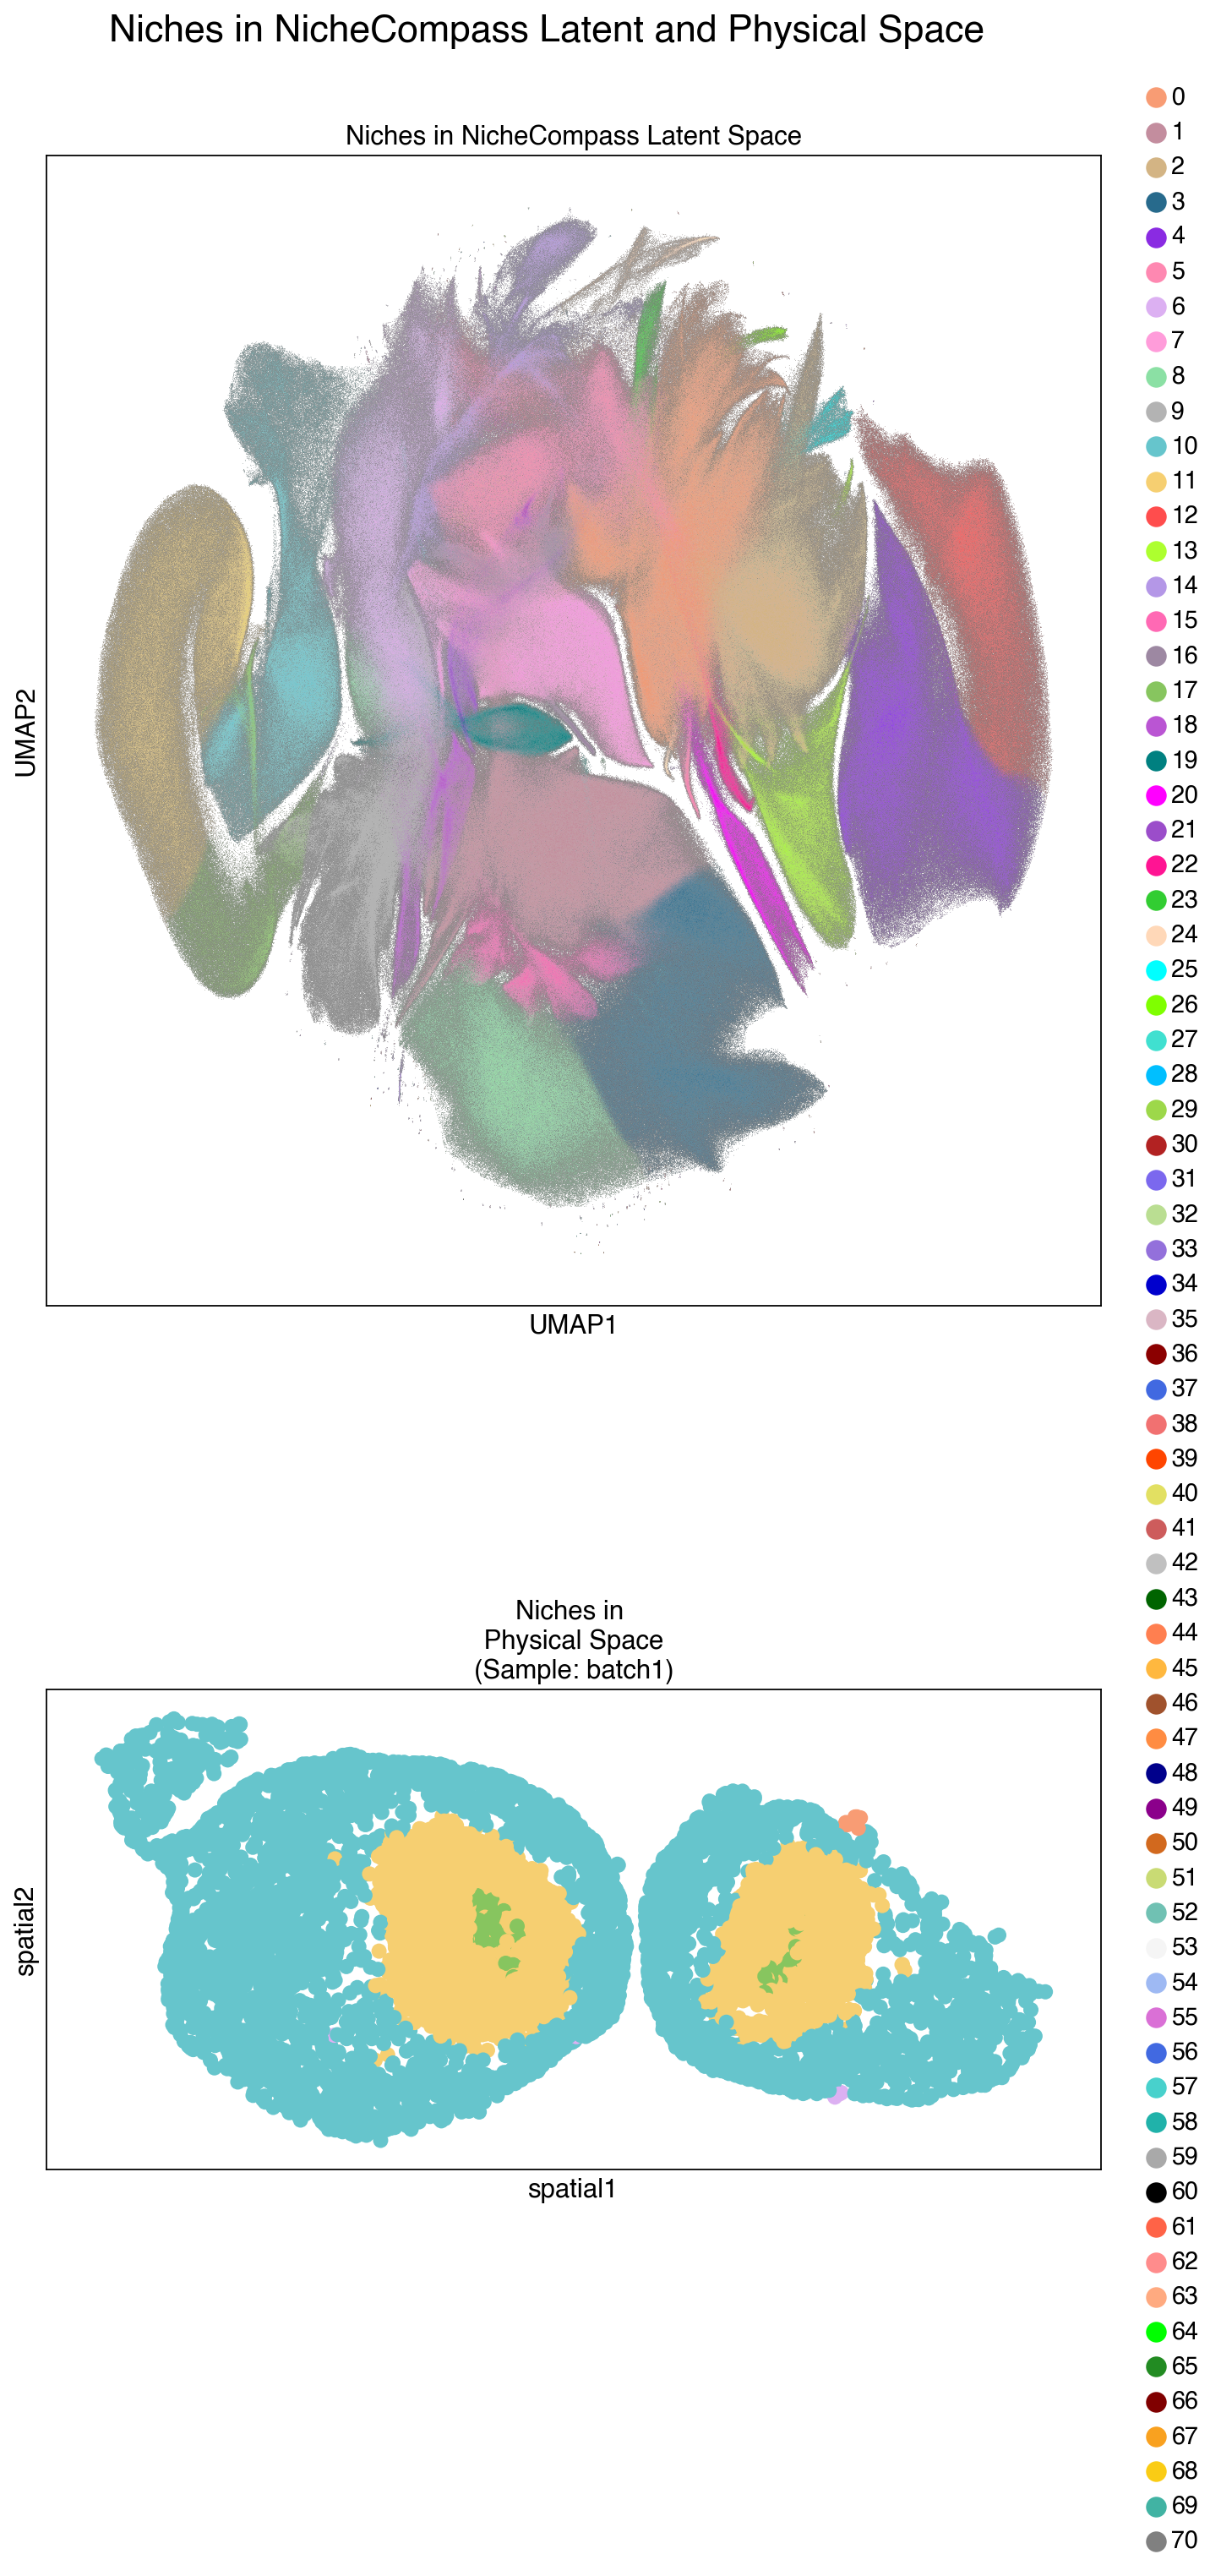

In [14]:
### Extended Data Fig. 8a ###
# Separate niches by major brain regions
for i, file in enumerate(["WB_MERFISH_animal1_coronal.h5ad",
                          "WB_MERFISH_animal3_sagittal.h5ad",
                          "WB_MERFISH_animal2_coronal.h5ad",
                          "WB_MERFISH_animal4_sagittal.h5ad"]):
    if i == 0:
        adata = sc.read_h5ad(f"{srt_data_bronze_folder_path}/merfish_mouse_brain/{file}")
    else:
        adata_subset = sc.read_h5ad(f"{srt_data_bronze_folder_path}/merfish_mouse_brain/{file}")
        adata = adata.concatenate(adata_subset, index_unique=None)
        del(adata_subset)
model.adata.obs = model.adata.obs.join(adata.obs[["major_brain_region"]], how='left')
del(adata)

for mbr in model.adata.obs["major_brain_region"].unique().tolist():
    if isinstance(mbr, str):
        condition = model.adata.obs['major_brain_region'] == mbr
        model.adata.obs[f'{mbr.lower()}_niches'] = np.where(condition, model.adata.obs['latent_leiden_0.2'], np.nan)

samples_subset = samples[:1]

latent_cluster_colors = create_new_color_dict(
        adata=model.adata,
        color_palette="default",
        cat_key=latent_cluster_key)

save_fig = True
file_path = f"{figure_folder_path}/" \
            "niches_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Niches",
    cat_key=latent_cluster_key,
    groups=None,
    sample_key=sample_key,
    samples=samples_subset,
    cat_colors=latent_cluster_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path,
    add_outline=True)

In [ ]:
batch_dict = {}
batch_dict["Olfactory"] = ["batch16", "batch18", "batch31", "batch219"]
batch_dict["Cerebellum"] = ["batch138", "batch228", "batch217"]
batch_dict["Thalamus"] = [ "batch95", "batch85", "batch186", "batch215"]
batch_dict["Hippocampus"] = ["batch99", "batch228", "batch218"]
batch_dict["Pallidum"] = ["batch71", "batch226", "batch223"]
batch_dict["Isocortex"] = ["batch86", "batch68", "batch220"]
batch_dict["Striatum"] = ["batch178", "batch229", "batch220"]
batch_dict["Hypothalamus"] = ["batch83", "batch94", "batch188", "batch215"]
batch_dict["Midbrain"] = ["batch203", "batch116", "batch197", "batch218"]
batch_dict["Cortical_subplate"] = ["batch227", "batch179", "batch78", "batch69"]
batch_dict["Fiber_tracts_ventricular_systems"] = ["batch127", "batch229", "batch217"]
batch_dict["Hindbrain"] = ["batch136", "batch191", "batch106", "batch219"]

categories = set(model.adata.obs["ventricular_systems_niches"].cat.categories) | set(model.adata.obs["fiber_tracts_niches"].cat.categories)
model.adata.obs["ventricular_systems_niches"] = model.adata.obs["ventricular_systems_niches"].cat.set_categories(categories)
model.adata.obs["fiber_tracts_niches"] = model.adata.obs["fiber_tracts_niches"].cat.set_categories(categories)
model.adata.obs["fiber_tracts_ventricular_systems_niches"] = model.adata.obs["ventricular_systems_niches"].fillna(model.adata.obs["fiber_tracts_niches"])
categories = set(model.adata.obs["pons_niches"].cat.categories) | set(model.adata.obs["medulla_niches"].cat.categories)
model.adata.obs["pons_niches"] = model.adata.obs["pons_niches"].cat.set_categories(categories)
model.adata.obs["medulla_niches"] = model.adata.obs["medulla_niches"].cat.set_categories(categories)
model.adata.obs["hindbrain_niches"] = model.adata.obs["pons_niches"].fillna(model.adata.obs["medulla_niches"])

for mbr in ["Striatum",
            "Olfactory",
            "Isocortex",
            "Pallidum",
            "Hippocampus",
            "Thalamus",
            "Cerebellum",
            "Hypothalamus",
            "Midbrain",
            "Cortical_subplate",
            "Fiber_tracts_ventricular_systems",
            "Hindbrain"]:
    if isinstance(mbr, str):
        save_fig = True
        file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                    f"{mbr}_latent_clusters_latent_physical_space.svg"

        plot_category_in_latent_and_physical_space(
            adata=model.adata,
            plot_label=mbr,
            cat_key=f"{mbr.lower()}_niches",
            groups=None,
            sample_key=sample_key,
            samples=samples, # batch_dict[mbr]
            cat_colors=latent_cluster_colors,
            size=(720000 / len(model.adata)),
            spot_size=spot_size,
            save_fig=save_fig,
            file_path=file_path,
            add_outline=True)

In [ ]:
# Determine length of scale bars
sample = 'batch106'
cat_key = 'latent_leiden_0.2'
groups = None
cat_colors = latent_cluster_colors

sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
              color=[cat_key],
              groups=groups,                  
              palette=cat_colors,
              spot_size=spot_size,
              title='',
              legend_loc=None,
              show=True)

adata = model.adata[model.adata.obs[sample_key] == sample]
max(adata.obsm['spatial'][:, 0]) - min(adata.obsm['spatial'][:, 0]) # microns

In [ ]:
### Extended Data Fig. 8b ###
brain_region_colors = create_new_color_dict(
    adata=model.adata,
    color_palette="default",
    cat_key="major_brain_region",
    skip_default_colors=60)

save_fig = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            "major_brain_region_latent_physical_space_subset.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Major Brain Region",
    add_outline=True,
    cat_key="major_brain_region",
    groups=None,
    sample_key=sample_key,
    samples=samples_subset,
    cat_colors=brain_region_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

In [ ]:
### Extended Data Fig. 8c ###
donor_colors = create_new_color_dict(
    adata=model.adata,
    color_palette="batch",
    cat_key="donor_id")

save_fig = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            "donor_latent_physical_space_subset.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Donor",
    add_outline=True,
    cat_key="donor_id",
    groups=None,
    sample_key=sample_key,
    samples=samples_subset,
    cat_colors=donor_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

### 3.2 Save Results

In [ ]:
# Log normalize counts for cellxgene server
model.adata.layers['counts'] = model.adata.X
sc.pp.normalize_total(model.adata, target_sum=1e4)
sc.pp.log1p(model.adata)

# Store gp summary in adata
gp_summary = model.get_gp_summary()
for col in gp_summary.columns:
    gp_summary[col] = gp_summary[col].astype(str)
model.adata.uns["nichecompass_gp_summary"] = gp_summary

model.adata.write(f"{result_folder_path}/{dataset}_analysis.h5ad")